In [1]:
from comparing_imgs_ssim import *
import cv2
import numpy as np
import skimage.exposure

In [2]:
DATASET_PATH = os.path.join('data', 'dataset', 'sygrisampol_images')
# dirnames = glob.glob(os.path.join(DATASET_PATH, "*", ""))

post_contrast_imgs = glob.glob(os.path.join(DATASET_PATH, "*_post-contrast.tif"))
pre_contrast_imgs = glob.glob(os.path.join(DATASET_PATH, "*_pre-contrast.tif"))
flair_imgs = glob.glob(os.path.join(DATASET_PATH, "*_flair.tif"))

stuff = {
    'post_contrast_imgs': post_contrast_imgs,
    'pre_contrast_imgs': pre_contrast_imgs,
    'flair_imgs': flair_imgs
}

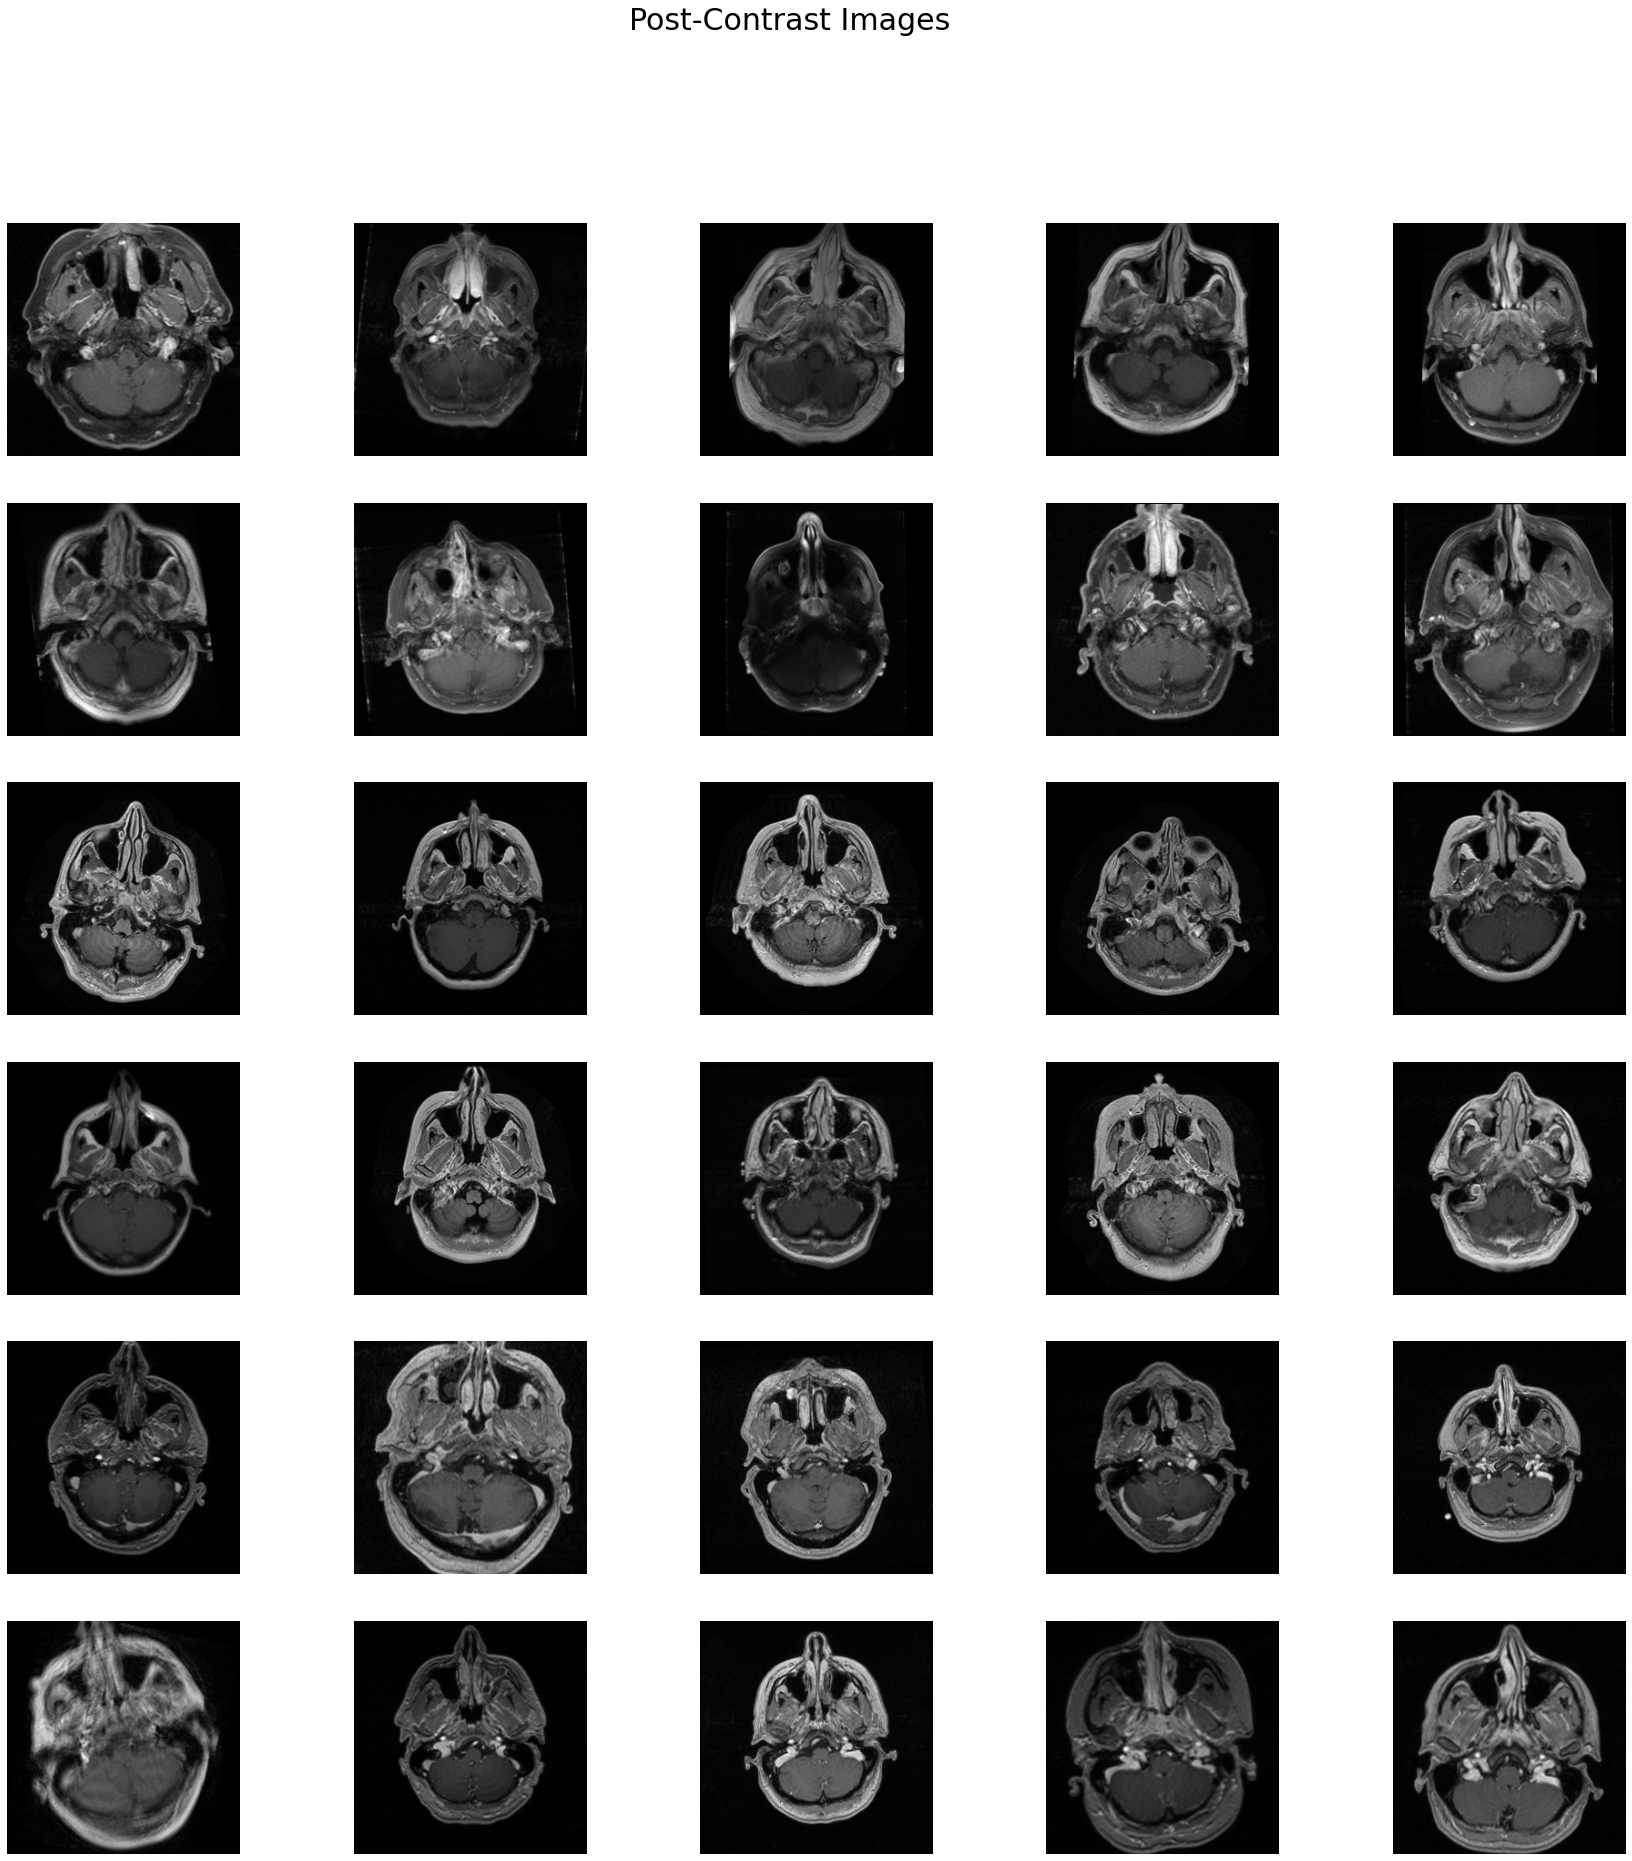

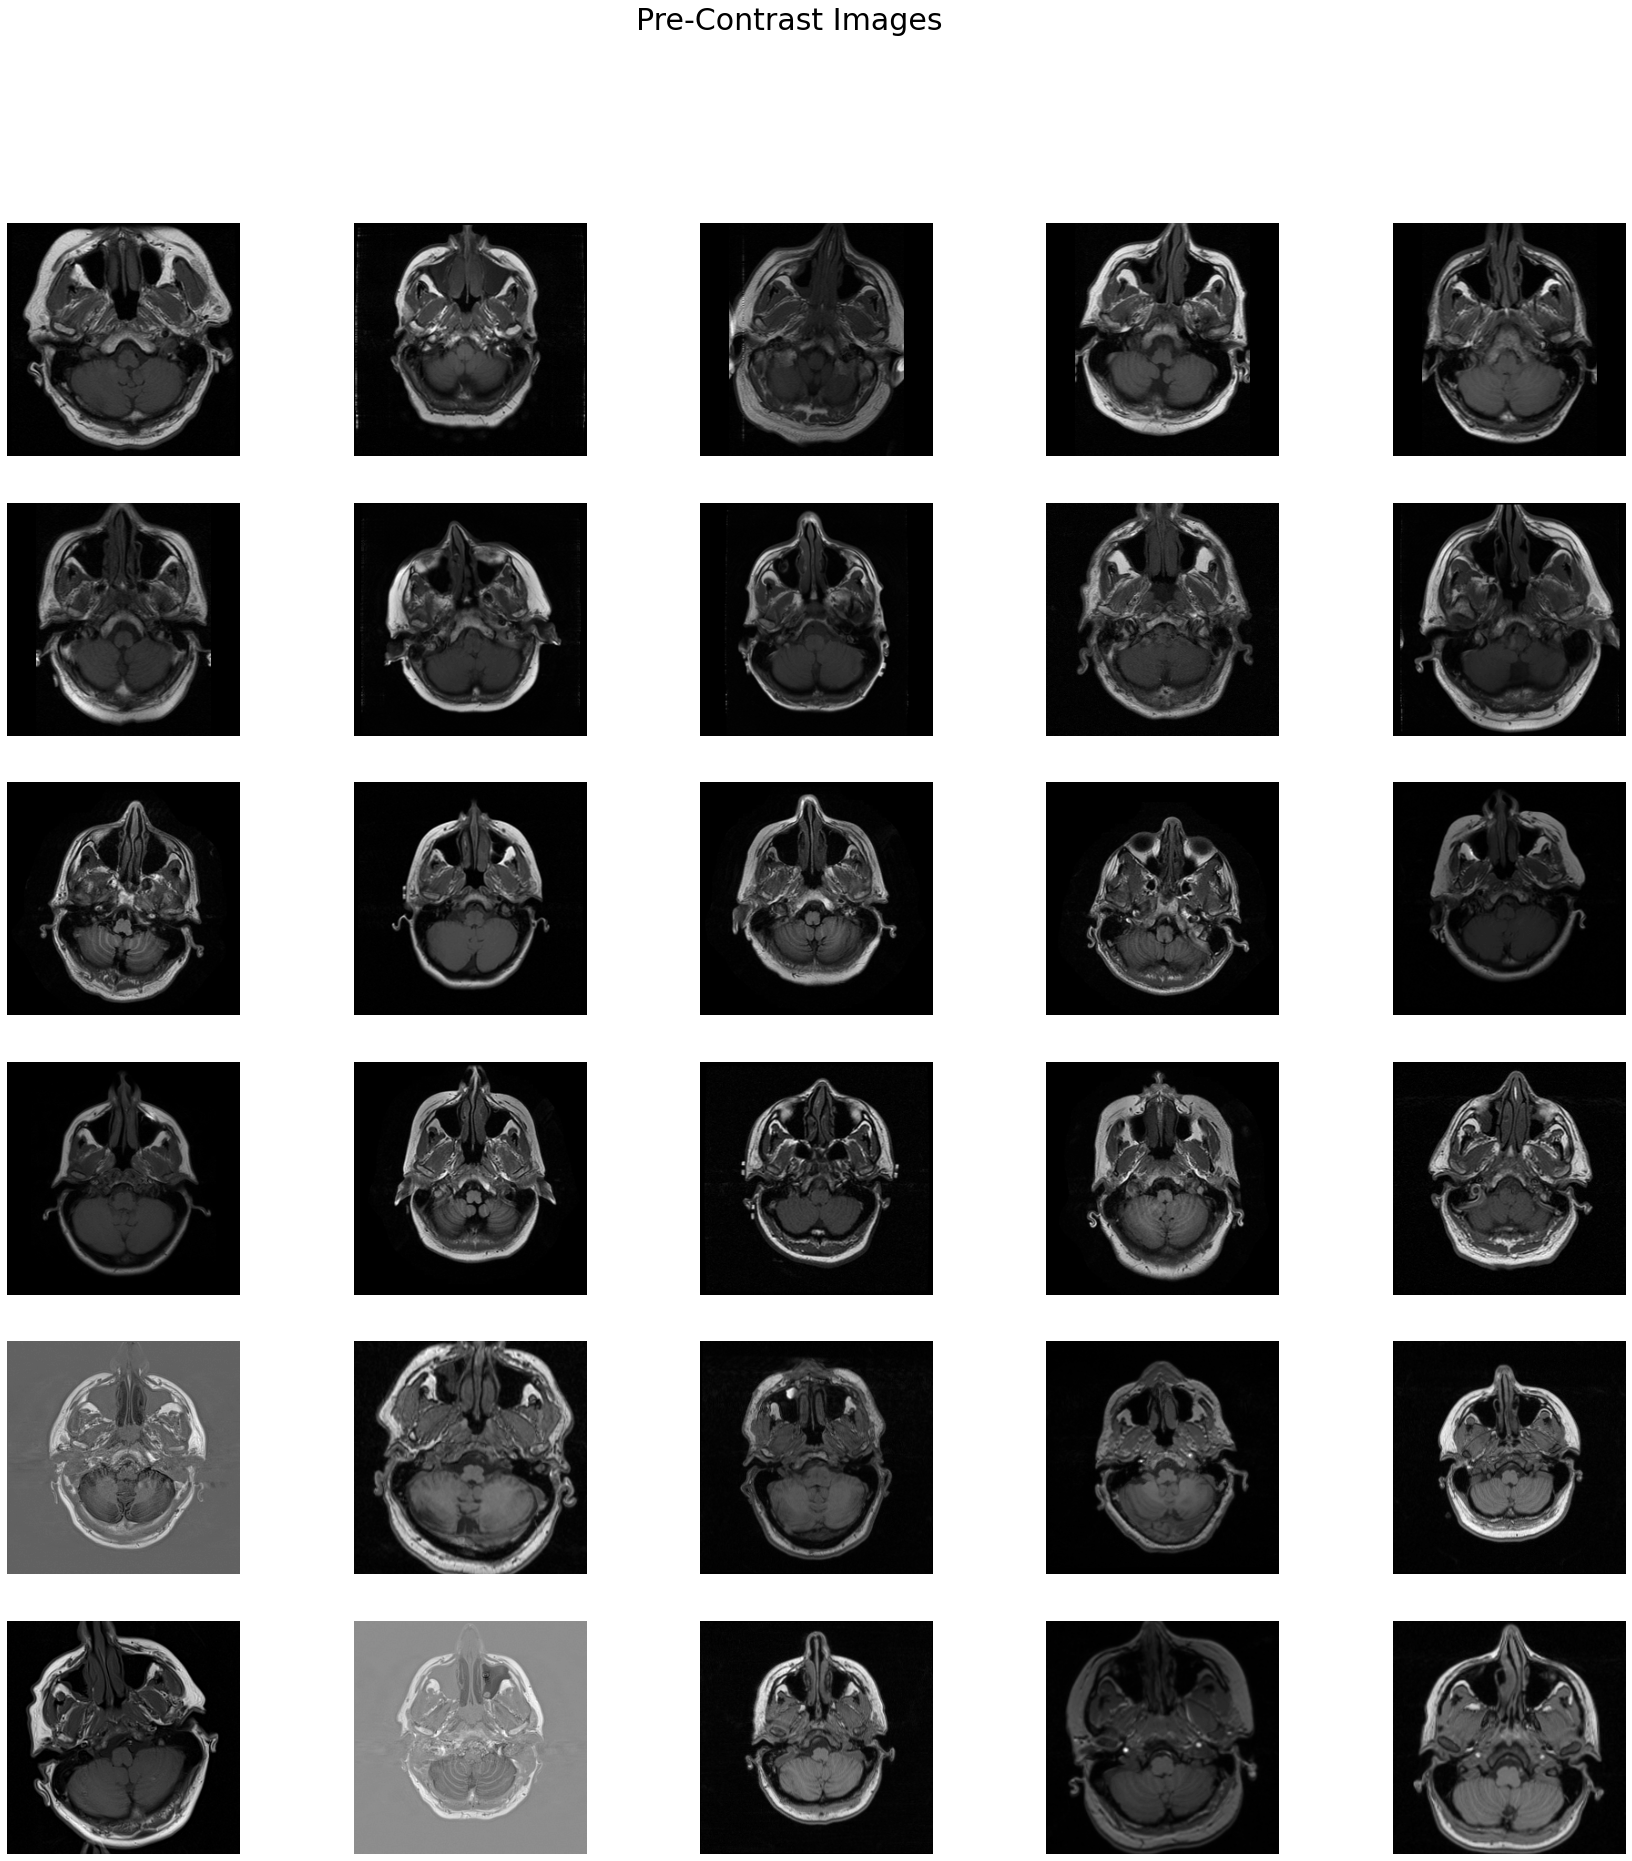

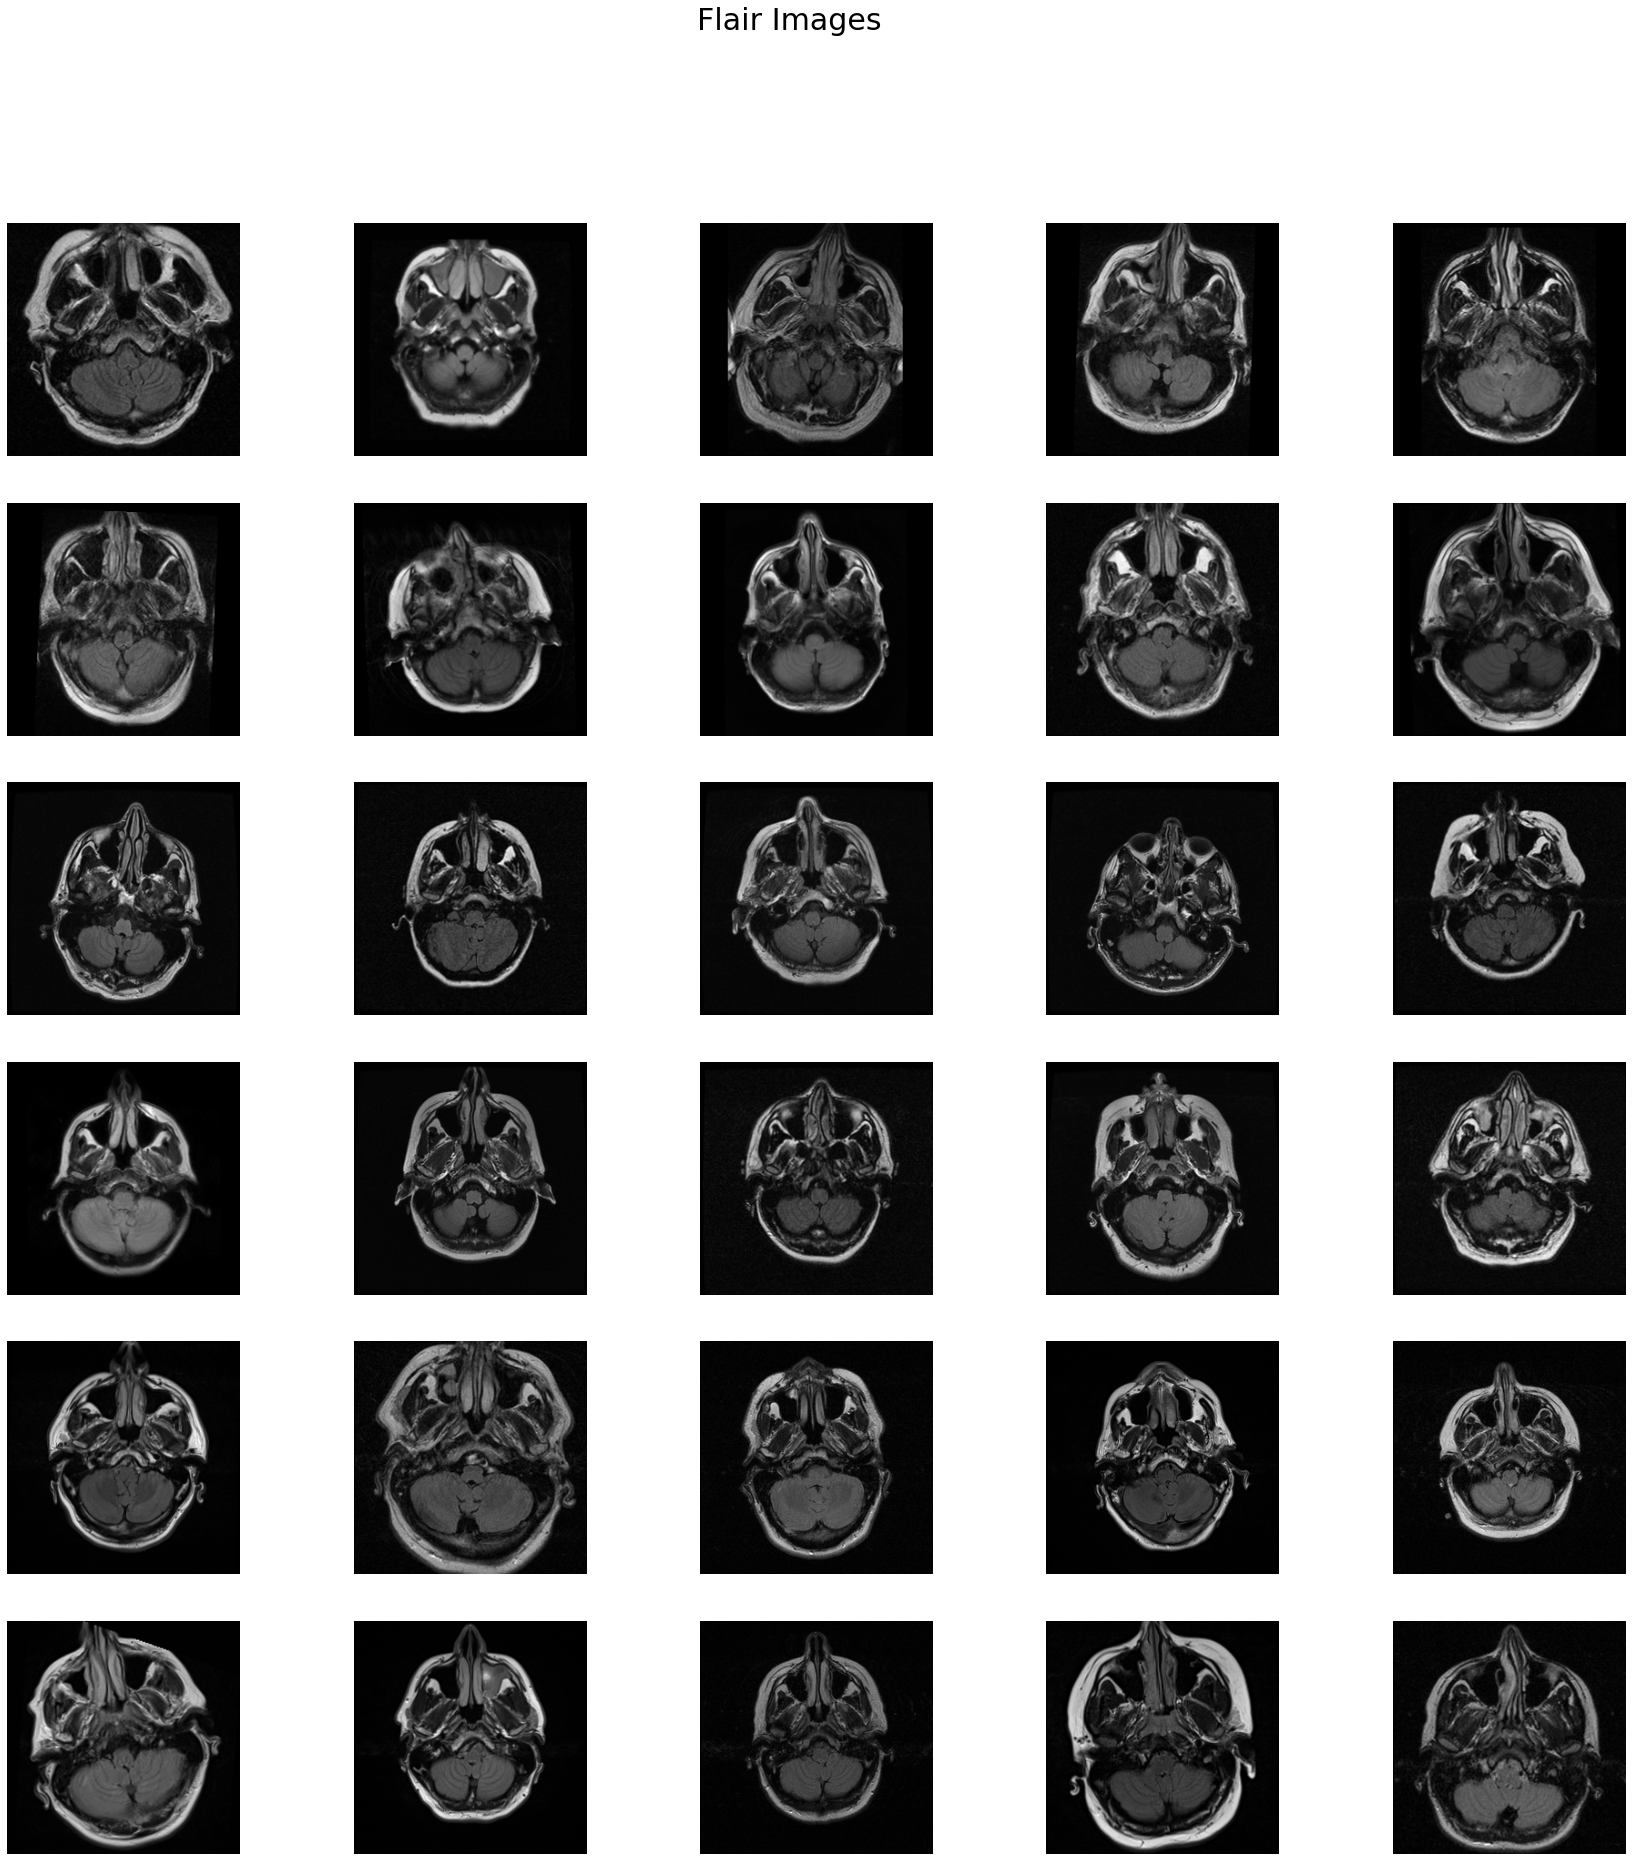

In [21]:
for title, s in stuff.items():
    list_of_imgs = list()
    for raw_img in s:
        img = cv2.imread(raw_img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        list_of_imgs.append(img)
    
    for i, img in enumerate(list_of_imgs):
        if s == stuff['post_contrast_imgs']:
            fig = plt.figure('Post-Contrast Images', figsize=(30, 30))
            plt.suptitle("Post-Contrast Images", fontsize=30)
        elif s == stuff['pre_contrast_imgs']:
            fig = plt.figure('Pre-Contrast Images', figsize=(30, 30))
            plt.suptitle("Pre-Contrast Images", fontsize=30)
        else:
            fig = plt.figure('Flair Images', figsize=(30, 30))
            plt.suptitle("Flair Images", fontsize=30)
        
        ax = fig.add_subplot(6, 5, i + 1)
        plt.imshow(img, cmap=plt.cm.gray)
        plt.axis("off")
    
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.draw()
    plt.savefig(f'.\\data\\dataset\\sygrisampol_images\\all_{title}_imgs.png')

In [22]:
def remove_background(file_name):

    # load image
    img = cv2.imread(file_name)

    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # threshold
    thresh = cv2.threshold(gray, 11, 255, cv2.THRESH_BINARY)[1]

    # apply morphology to clean small spots
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=0)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=0)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    morph = cv2.morphologyEx(morph, cv2.MORPH_ERODE, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=0)

    # get external contour
    contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    big_contour = max(contours, key=cv2.contourArea)

    # draw white filled contour on black background as mas
    contour = np.zeros_like(gray)
    cv2.drawContours(contour, [big_contour], 0, 255, -1)

    # blur dilate image
    blur = cv2.GaussianBlur(contour, (5,5), sigmaX=0, sigmaY=0, borderType = cv2.BORDER_DEFAULT)

    # stretch so that 255 -> 255 and 127.5 -> 0
    mask = skimage.exposure.rescale_intensity(blur, in_range=(127.5,255), out_range=(0,255))

    # put mask into alpha channel of input
    result = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
    result[:,:,3] = mask

    # save output
#     cv2.imwrite('aerial_image_thresh.png', thresh)
#     cv2.imwrite('aerial_image_morph.png', morph)
#     cv2.imwrite('aerial_image_contour.png', contour)
#     cv2.imwrite('aerial_image_mask.png', mask)
    cv2.imwrite(f'{file_name}_removed_background.png', result)


    # Display various images to see the steps
#     cv2.imshow('thresh', thresh)
#     cv2.imshow('morph', morph)
#     cv2.imshow('contour', contour)
#     cv2.imshow('mask', mask)
#     cv2.imshow('result', result)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [23]:
for title, s in stuff.items():
    list_of_imgs = list()
    for raw_img in s:
        remove_background(raw_img)